# Erosion fluviale

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from matplotlib import animation
import pyproj
from IPython.display import HTML
import requests
from io import BytesIO

# Implémentation de l'érosion

On utilise l'équation de stream power pour calculer le taux d'érosion $E$ $(L T^{-1})$:
$$
E = K_f\text{ . } A(x)^m\text{ . } S(x)^n
$$
avec :

$K_f$ = le coefficient d'érosion fluviatile,\
$S$ = la pente,\
$A $ = le coefficient spatial d'érosion,\
$m,n \in \mathbb{Z}\text{ .}$\
\
Généralement, $\frac{m}{n} = \frac{1}{2}$ dans de nombreux modèles d’érosion.\
\
$K_f$ $(L^{1−2m} T^{−1})$ le coefficient d'érosion fluviatile, qui dépend notamment de la lithologie\
$S$ la pente locale,\
$A (L^2)$ zone de drainage qui paramétrise l'espace le long de la rivière et qui dépend de sa largeur,\
$m$  l'exposant de surface,\
et $n$ l'exposant de pente.\
Généralement, $\frac{m}{n} = \frac{1}{2}$ dans de nombreux modèles d’érosion.

Pour simuler le fait que l'érosion est plus forte au centre du lit d'une rivière que sur les côtés (pour une rivière droite), on paramétrise $A$ avec une gaussienne, où l'écart type est
$$ \sigma = w/2 $$
et la moyenne est définie comme $$ \mu = l/2 $$

$$ A(x) =  e^\frac{-(x- \mu)^2}{2 \sigma^2}$$ 

avec $w$ la largeur du lit de la rivière et $l$ la longueur du domaine considéré. Cela permet de modéliser le profil en V qui se développe suite à de l'érosion fluviatile.

Voici à quoi ressemble le profil de A:

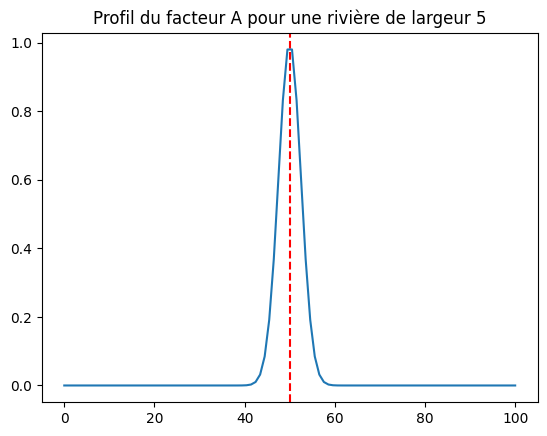

In [3]:
longueur = 100
river_width = 5
sigma = river_width/2
mu = longueur/2
x = np.linspace(0, longueur, longueur)
#A = (1/(sigma*np.sqrt(2*np.pi)))*np.exp(-(x-mu)**2/(2*sigma**2))
A = np.exp(-(x-mu)**2/(2*sigma**2))
plt.axvline(x=longueur/2, color='red', linestyle='--', label=f'Centre de la rivière (x = {longueur/2})')
plt.plot(x,A, label = "A")
#plt.legend()
plt.title(f"Profil du facteur A pour une rivière de largeur {river_width}")
plt.show()

In [54]:
def calc_slope(mnt):

    if np.ndim(mnt) == 1:
        slope = np.abs(np.gradient(mnt))
        
    else:
        dx, dy = np.gradient(mnt)
        slope = np.sqrt(np.clip(dx**2 + dy**2, 0, 1e6))
        
    slope = np.maximum(slope, 1e-3)  # Valeur minimale pour éviter S = 0
    return slope
    
def erosion(mnt, K, A, m, n):
    S = calc_slope(mnt)
    E = K * (A**m) * (S**n) 
    return E


def app_erosion(x,mnt, K, m, n, time, river_width, longueur,stop):
    list_mnt = []    

    sigma = river_width/2
    mu = longueur/2
    A = np.exp(-(x-mu)**2/(sigma**2))
    
    for t in range(time):
        
        mnt -= erosion(mnt, K, A, m, n)
        list_mnt.append(mnt.copy())  # Copie pour éviter l'écrasement des données
        
        if stop == True:
            if np.any(mnt <= 0):
                print("STOP à l'itération", t)  #Permet d'arrêter les itérations si une des valeurs du terrain arrive à 0.
                break
        
    return list_mnt

# Terrain en 1D
## (ie: coupe topographique)

### Terrain plat
On paramétrise la coupe avec une fonction constante, à laquelle on ajoute des variations de l'ordre de 0.0001, ce qui permet d'avoir un résultat différent à chaque exécution du code.

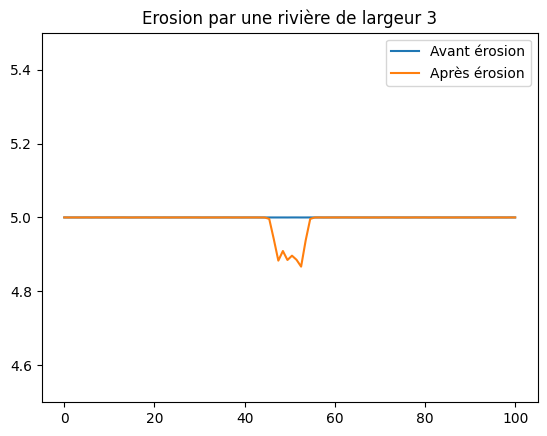

In [68]:
longueur = int(100)
altitude = 5

x = np.linspace(0,longueur,100)
topo = altitude*(x)**0 
topo += 1e-4*np.random.rand(np.size(x)) #On ajoute des toutes petites variations aléatoires

topo_erode = app_erosion(x,topo.copy(), K=0.1, m=0.5, n=1, time=500, river_width = 3, longueur=longueur, stop = False)

plt.ylim(altitude - altitude/10, altitude + altitude/10)
plt.plot(x,topo, label = "Avant érosion")
plt.plot(x, topo_erode[-1], label = "Après érosion")
plt.title("Erosion par une rivière de largeur 3")
plt.legend()
plt.grid(False)
plt.show()

### Terrain en vallée
On paramétrise la coupe avec une parabole d'équation $$ y = (0.01 (x-l/2))^2 + altitude $$

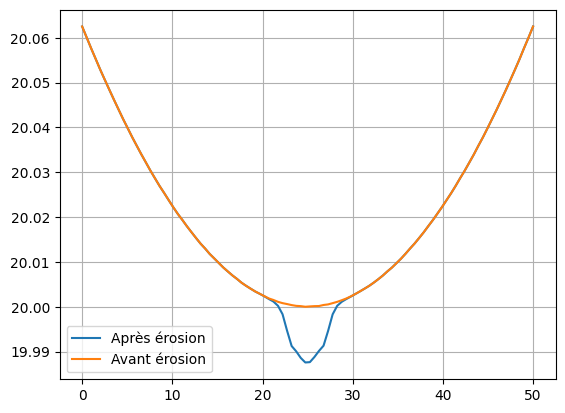

In [113]:
longueur = 50
altitude = 20

x = np.linspace(0,longueur,100)

topo = altitude+(0.01*(x-longueur/2))**2

topo += 1e-4*np.random.rand(np.size(x)) #On ajoute des toutes petites variations aléatoires

topo_erode = app_erosion(x,topo.copy(), K=1e-1, m=0.5, n=1, time=200, river_width = 2, longueur=longueur, stop = False)

plt.plot(x, topo_erode[-1], label = "Après érosion")
plt.plot(x,topo, label = "Avant érosion")
plt.legend()
plt.grid(True)
plt.show()

# Terrain en 2D

## Terrain en vallées randomisé
On paramétrise la vallée initiale comme suit : $$ Z(X,Y) = \frac{h}{2} sin(0.1 X) + \frac{h}{2} cos(0.1 Y) +h $$
où h est une altitude de base qu'on détermine arbitrairement.

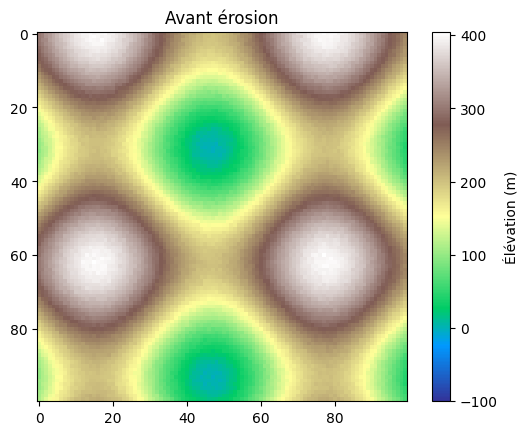

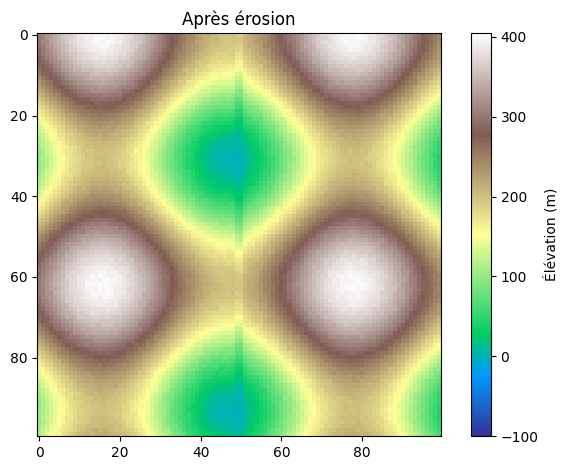

In [114]:
largeur = 100
longueur = 100

x = np.linspace(0,largeur, largeur)
y=np.linspace(0,longueur,longueur)
[X,Y] = np.meshgrid(x,y)

altitude = 200 

topo = np.full_like(X, altitude)

topo = altitude/2*np.sin(0.1*X) + altitude + altitude/2*np.cos(0.1*Y)

random_variation = 1*np.random.randn(*topo.shape) * 2  # Variation aléatoire

topo += random_variation  

topo_erode = app_erosion(X,topo.copy(), K=0.1, m=0.5, n=1, time=30, river_width=1, longueur=longueur,stop=False)

fig, ax = plt.subplots()

# Définir les limites de la colorbar
vmin = np.min(topo)  # Valeur minimale de l'image
vmax = np.max(topo)  # Valeur maximale de l'image

cax = ax.imshow(topo, cmap='terrain', vmin=-100, vmax=vmax)
plt.title("Avant érosion")
plt.colorbar(cax, label='Élévation (m)')


fig, ax = plt.subplots()
cax = ax.imshow(topo_erode[-1], cmap='terrain', vmin=-100, vmax=vmax)
plt.title("Après érosion")


plt.colorbar(cax, label='Élévation (m)', ax=ax)

plt.tight_layout()

plt.show()

## Louvain-la-Neuve

Système de coordonnées (CRS) : EPSG:3035
Transformation affine : | 30.00, 0.00, 3938820.00|
| 0.00,-30.00, 3077230.00|
| 0.00, 0.00, 1.00|


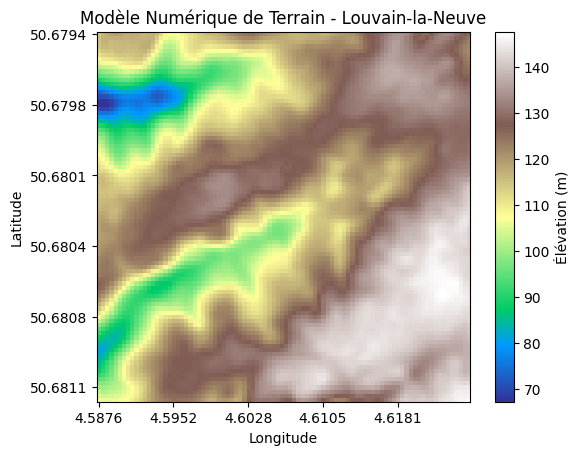

In [8]:
# Charger le fichier TIFF
file_url = "https://raw.githubusercontent.com/clemence-g/Glacial-fluvial-erosion/ead0229ef83b09ad99bdae3903d0d009654fc5f0/data/lln.tif"
response = requests.get(file_url)
response.raise_for_status()

# Lire le fichier avec rasterio depuis un flux en mémoire
with rasterio.Env():
    with rasterio.open(BytesIO(response.content)) as src:
        lln = src.read(1)  # Lecture de la première couche (altitudes)
        transform = src.transform

with rasterio.open(file_url) as src:
    # Afficher les informations de projection et de transformation
    print("Système de coordonnées (CRS) :", src.crs)
    print("Transformation affine :", src.transform)


# Définir les systèmes de projection (Lambert 93 et WGS84)
lambert93 = pyproj.CRS("EPSG:3035")
wgs84 = pyproj.CRS("EPSG:4326")

# Créer un transformateur de projection
transformer = pyproj.Transformer.from_crs(lambert93, wgs84, always_xy=True)

# Convertir les indices des pixels en coordonnées projetées (EPSG:3035)
x_indices, y_indices = np.meshgrid(np.arange(lln.shape[1]), np.arange(lln.shape[0]))
x_proj, y_proj = rasterio.transform.xy(transform, y_indices, x_indices)

# Appliquer la transformation pour convertir en latitude/longitude (EPSG:4326)
longitudes, latitudes = transformer.transform(x_proj, y_proj)

fig, ax = plt.subplots()

cax = ax.imshow(lln, cmap='terrain')

plt.colorbar(cax, label='Élévation (m)')

# Modifier les étiquettes des axes avec les coordonnées géographiques
ax.set_xticks(np.arange(0, lln.shape[1], int(lln.shape[1] / 5)))
ax.set_yticks(np.arange(0, lln.shape[0], int(lln.shape[0] / 5)))

# Utiliser les coordonnées en degrés pour les étiquettes
ax.set_xticklabels([f"{longitudes[i]:.4f}" for i in range(0, lln.shape[1], int(lln.shape[1] / 5))])
ax.set_yticklabels([f"{latitudes[i]:.4f}" for i in range(0, lln.shape[0], int(lln.shape[0] / 5))])

ax.set_xlabel('Longitude') 
ax.set_ylabel('Latitude') 

plt.title('Modèle Numérique de Terrain - Louvain-la-Neuve')
plt.show()

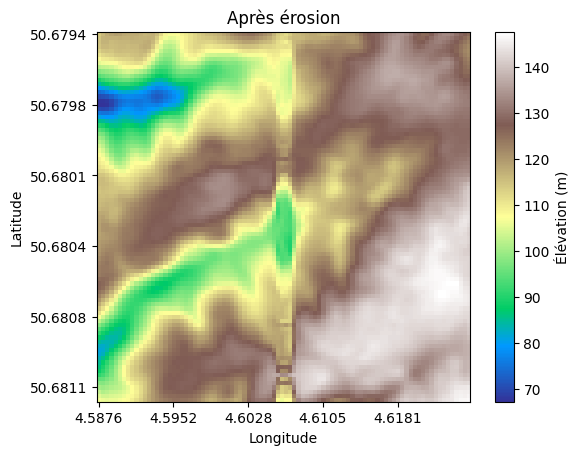

In [120]:
x = np.linspace(0,np.shape(lln)[1], np.shape(lln)[1])
lln_erode = app_erosion(x, lln.copy(), K=0.1, m=0.5, n=1, time=100, river_width=2, longueur=np.shape(lln)[1],stop=True)

# Définir les limites de la colorbar
vmin = np.min(lln)  # Valeur minimale de l'image
vmax = np.max(lln)  # Valeur maximale de l'image

fig, ax = plt.subplots()
cax = ax.imshow(lln_erode[-1], cmap='terrain', vmin=vmin, vmax=vmax)
plt.title("Après érosion")

# Modifier les étiquettes des axes avec les coordonnées géographiques
ax.set_xticks(np.arange(0, lln.shape[1], int(lln.shape[1] / 5)))
ax.set_yticks(np.arange(0, lln.shape[0], int(lln.shape[0] / 5)))

# Utiliser les coordonnées en degrés pour les étiquettes
ax.set_xticklabels([f"{longitudes[i]:.4f}" for i in range(0, lln.shape[1], int(lln.shape[1] / 5))])
ax.set_yticklabels([f"{latitudes[i]:.4f}" for i in range(0, lln.shape[0], int(lln.shape[0] / 5))])

ax.set_xlabel('Longitude') 
ax.set_ylabel('Latitude') 

plt.colorbar(cax, label='Élévation (m)', ax=ax)
plt.show()


### Coupe topographique

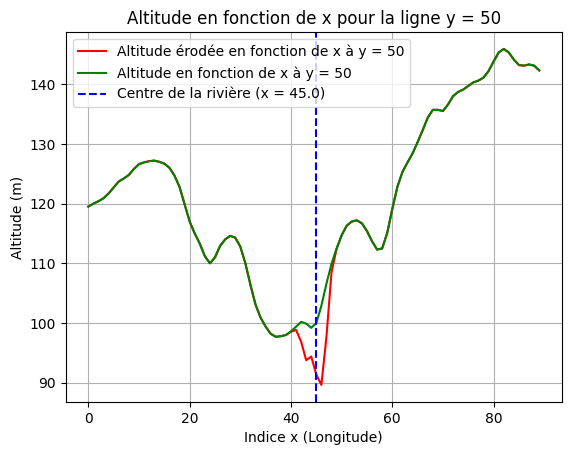

In [117]:
# Récupérer les valeurs d'altitude pour la ligne où y = 50

y_index = 50  
altitudes_at_y_50 = lln[y_index,:]  

altitudes_at_y_50_erode = lln_erode[-1][y_index,:]  

x_indices = np.arange(lln.shape[1])  # Indices des lignes

# Tracer l'altitude en fonction de x

plt.plot(x_indices, altitudes_at_y_50_erode, label='Altitude érodée en fonction de x à y = 50', color='red')
plt.plot(x_indices, altitudes_at_y_50, label='Altitude en fonction de x à y = 50', color='green')

plt.xlabel('Indice x (Longitude)')
plt.ylabel('Altitude (m)')
plt.title('Altitude en fonction de x pour la ligne y = 50')

plt.axvline(x=lln.shape[1]/2, color='blue', linestyle='--', label=f'Centre de la rivière (x = {lln.shape[1]/2})')

plt.grid(True)


plt.legend()
plt.show()


# Références
- Campforts, B., and G. Govers. (2015). Keeping the edge: A numerical method that avoids knickpoint smearing when solving the stream power law. J. _Geophys. Res. Earth Surf._, 120, 1189–1205. https://doi.org/10.1002/2014JF003376. Accessed: 2024-12-05.
- Hergarten, Stefan. (2021). A stream-power law for glacial erosion and its implementation in large-scale landform-evolution models.  https://doi.org/10.5194/esurf-2021-1. Accessed: 2024-12-05.
- Hengl, Tomislav, Leal Parente, Leandro, Krizan, Josip, and Bonannella, Carmelo. (2022). Continental Europe Digital Terrain Model.  Distributed by OpenTopography. https://doi.org/10.5069/G99021ZF. Accessed: 2024-12-05.